<a href="https://colab.research.google.com/github/puginarug/streamlit_cell_migration/blob/main/cell_migration_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Object-Oriented Cell Migration Simulation

This notebook simulates cell migration as a 2D random walk with constant speed and random direction at each time step. It includes methods to calculate:

- Mean Squared Displacement (MSD)
- Velocity Autocorrelation (VAC)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Cell Class

Each cell has:

- `positions`: Recorded (x, y) positions over time
- `velocities`: Recorded velocity vectors over time

Methods:

- `step(dt, speed)`: Move cell by drawing a new random direction and updating position.

In [ ]:
class Cell:
    def __init__(self, cell_id, x0=0.0, y0=0.0):
        self.id = cell_id
        self.positions = [(x0, y0)]
        self.velocities = []  # (vx, vy)

    def step(self, dt, speed):
        # Random direction
        theta = np.random.uniform(0, 2 * np.pi)
        vx = speed * np.cos(theta)
        vy = speed * np.sin(theta)
        # Update position
        x_prev, y_prev = self.positions[-1]
        x_new = x_prev + vx * dt
        y_new = y_prev + vy * dt
        # Record
        self.velocities.append((vx, vy))
        self.positions.append((x_new, y_new))

## Simulation Class

Manages multiple cells over discrete time steps.

Methods:

 - `run(n_steps)`: Simulate for `n_steps`.
 - `get_positions_array()`: Returns a NumPy array of shape (n_cells, n_steps+1, 2).
 - `get_velocities_array()`: Returns shape (n_cells, n_steps, 2).
 - `compute_msd(max_lag)`: Computes MSD for lags `1..max_lag`.
 - `compute_vac(max_lag)`: Computes velocity autocorrelation.

In [ ]:
class Simulation:
    def __init__(self, n_cells=10, dt=1.0, speed=1.0):
        self.n_cells = n_cells
        self.dt = dt
        self.speed = speed
        self.cells = [Cell(i) for i in range(n_cells)]
        self.n_steps = 0

    def run(self, n_steps):
        self.n_steps = n_steps
        for _ in range(n_steps):
            for cell in self.cells:
                cell.step(self.dt, self.speed)

    def get_positions_array(self):
        # Shape: (n_cells, n_steps+1, 2)
        return np.array([cell.positions for cell in self.cells])

    def get_velocities_array(self):
        # Shape: (n_cells, n_steps, 2)
        return np.array([cell.velocities for cell in self.cells])

    def compute_msd(self, max_lag=None):
        pos = self.get_positions_array()
        n_cells, T, _ = pos.shape
        if max_lag is None:
            max_lag = T - 1
        msd = np.zeros(max_lag)
        for lag in range(1, max_lag + 1):
            disp2 = []
            for c in range(n_cells):
                for t in range(T - lag):
                    dx = pos[c, t + lag, 0] - pos[c, t, 0]
                    dy = pos[c, t + lag, 1] - pos[c, t, 1]
                    disp2.append(dx**2 + dy**2)
            msd[lag-1] = np.mean(disp2)
        return msd

    def compute_vac(self, max_lag=None):
        vel = self.get_velocities_array()
        n_cells, Tm, _ = vel.shape
        if max_lag is None:
            max_lag = Tm - 1
        vac = np.zeros(max_lag)
        for lag in range(1, max_lag + 1):
            acs = []
            for c in range(n_cells):
                for t in range(Tm - lag):
                    v0 = np.array(vel[c, t])
                    vlag = np.array(vel[c, t + lag])
                    acs.append(np.dot(v0, vlag))
            vac[lag-1] = np.mean(acs)
        return vac

## Run Simulation and Plot Results

We simulate `n_cells` for `n_steps` and plot:

 1. Sample trajectories
 2. Mean Squared Displacement (MSD)
 3. Velocity Autocorrelation (VAC)

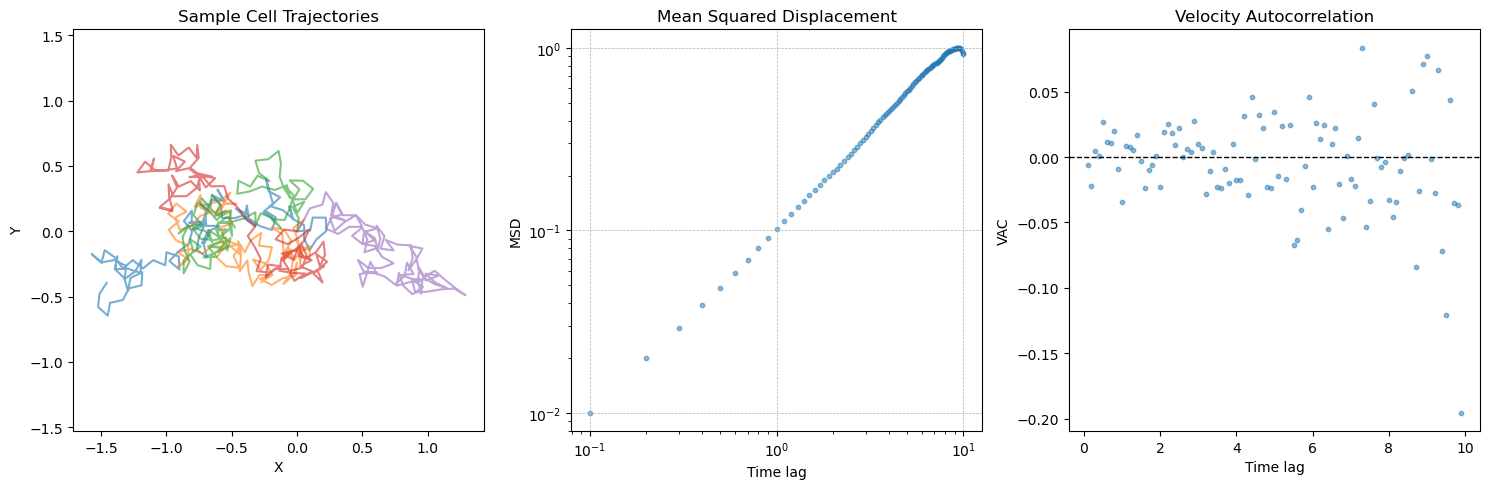

In [ ]:
# Parameters
n_cells = 20
n_steps  = 100
dt       = 0.1
speed    = 1.0

# Run simulation
sim = Simulation(n_cells=n_cells, dt=dt, speed=speed)
sim.run(n_steps)

# Retrieve data
positions = sim.get_positions_array()  # shape (n_cells, n_steps+1, 2)
msd       = sim.compute_msd()          # length = n_steps
vac       = sim.compute_vac()          # length = n_steps

# Time lags
t = np.arange(1, len(msd)+1) * dt

# Create figure with 1×3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Panel A: Sample trajectories
ax = axes[0]
for c in range(min(n_cells, 5)):
    traj = positions[c]
    ax.plot(traj[:, 0], traj[:, 1], alpha=0.6)
ax.set_title('Sample Cell Trajectories')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.axis('equal')

# Panel B: MSD on log–log scale
ax = axes[1]
ax.scatter(t, msd, s=10, alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(which='major', linestyle='--', linewidth=0.5)
ax.set_title('Mean Squared Displacement')
ax.set_xlabel('Time lag')
ax.set_ylabel('MSD')

# Panel C: Velocity autocorrelation
ax = axes[2]
ax.scatter(t[:-1], vac, s=10, alpha=0.5)
ax.axhline(0, color='k', linestyle='--', linewidth=1)
ax.set_title('Velocity Autocorrelation')
ax.set_xlabel('Time lag')
ax.set_ylabel('VAC')

# Layout & display
plt.tight_layout()
plt.show()